In [1]:
import numpy as np
import pickle
import copy
import os

from scipy.stats import linregress

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_dir='/scratch/gpfs/jabbate/data_20_ms_ordered_all/'

with open(os.path.join(data_dir,'train.pkl'), 'rb') as f:
    data=pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/gpfs/jabbate/data_20_ms_ordered_all/train.pkl'

In [4]:
with open(os.path.join(data_dir,'param_dict.pkl'), 'rb') as f: 
    param_dict=pickle.load(f)

In [5]:
param_dict.keys()

dict_keys(['normalization_dict', 'rawdata_path', 'sig_names', 'normalization_method', 'window_length', 'window_overlap', 'lookbacks', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'nshots', 'flattop_only', 'input_profile_names', 'target_profile_names', 'actuator_names', 'scalar_names', 'efit_type', 'profile_lookback', 'actuator_lookback', 'basefilename'])

In [6]:
plt.rcParams['figure.figsize'] = [15, 10]
font={'size': 20, 'weight':'heavy'}
plt.rc('font', **font)

In [7]:
shots=np.unique(data['shotnum'][:,0])

In [39]:
print(shot_indices)

(array([429448, 429449, 429450, 429451, 429452, 429453, 429454, 429455,
       429456, 429457, 429458, 429459, 429460, 429461, 429462, 429463,
       429464, 429465, 429466, 429467, 429468, 429469, 429470, 429471,
       429472, 429473, 429474, 429475, 429476, 429477, 429478, 429479,
       429480, 429481, 429482, 429483, 429484, 429485, 429486, 429487,
       429488, 429489, 429490, 429491, 429492, 429493, 429494, 429495,
       429496, 429497, 429498, 429499, 429500, 429501, 429502, 429503,
       429504, 429505, 429506, 429507, 429508, 429509, 429510, 429511,
       429512, 429513, 429514, 429515]),)


Shot: 160288


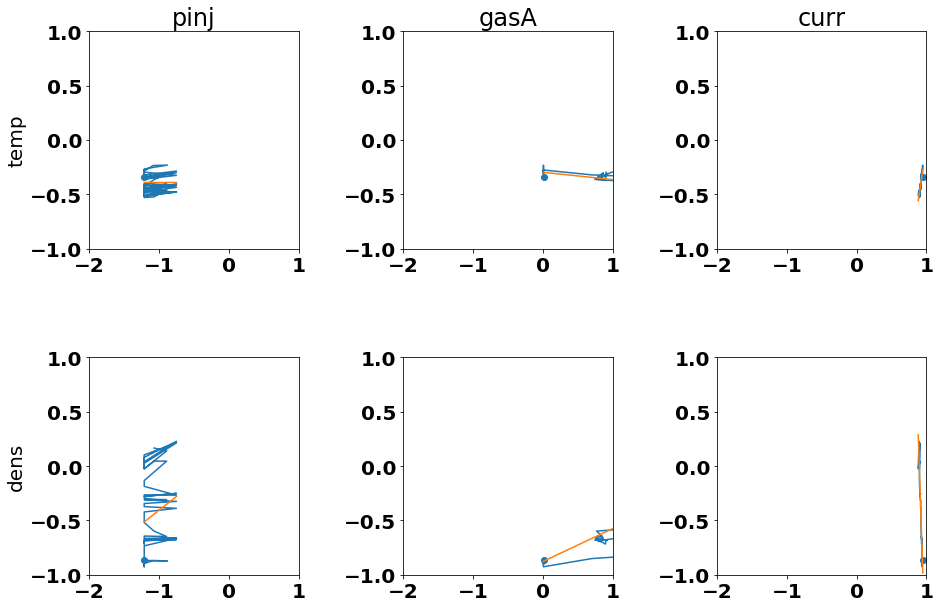

In [12]:
shot         = 160288 #shots[np.random.randint(len(shots))]
shot_indices = np.where(data['shotnum'][:,0]==shot)
shot_times   = data['time'][shot_indices][-param_dict['lookahead']]

print('Shot: {}'.format(shot))

fig=plt.figure()
ind_sigs=['pinj','gasA','curr']
dep_sigs=['temp','dens']

for j,dep_sig in enumerate(dep_sigs):
    for i,ind_sig in enumerate(ind_sigs):
        ax=fig.add_subplot('{}{}{}'.format(len(dep_sigs),len(ind_sigs),i+j*len(ind_sigs)+1))
        if i==0:
            ax.set_ylabel(dep_sig)
        if j==0:
            ax.set_title(ind_sig)

        #ax.set_xlim(-2,2)
        #ax.set_ylim(-2,2)
        x=data[ind_sig][shot_indices,-param_dict['lookahead']].squeeze()
        y=np.mean(data[dep_sig][shot_indices,-param_dict['lookahead']+1,:].squeeze(),axis=1)
        ax.plot(x,y)
        ax.scatter(x[0],y[0])
        ax.set_xlim((-2,1))
        ax.set_ylim((-1,1))
        
        slope, intercept, r_value, p_value, std_err = linregress(x,y)
        base_x=np.linspace(min(x),max(x),5)
        ax.plot(base_x,base_x*slope+intercept)
        
plt.subplots_adjust(hspace=.5)
plt.subplots_adjust(wspace=.5)

In [11]:
shot=156351 #np.random.choice(shots)
sigs=['pinj','temp']

for i,sig in enumerate(sigs):
    ax=fig.add_subplot(len(sigs),1.5,i+1)
    #ax.axvline(data[shot]['t_ip_flat'],c='r')
    ax.axvline(data[shot]['t_ip_flat']+data[shot]['ip_flat_duration'],c='r')
    if sig in ['temp','dens']: #len(data[shot][sig].shape)>1:
        thomson_sig_name='thomson_{}_EFITRT1'.format(sig)
        thomson_sig=data[shot][thomson_sig_name]
        thomson_sig=removeOutliers(thomson_sig,1.5,thomson_sig_name)
        
        ax.contourf(data[shot]['time'],
                    np.linspace(0,1,65),
                    #thomson_sig.T)
                    data[shot][sig].T)
            
        zipfit_sig=my_normalize(np.mean(data[shot][sig],axis=1))
        ax.plot(data[shot]['time'],zipfit_sig,c='y',linewidth=7)
        ax.plot(data[shot]['time'],zipfit_sig,c='r',linewidth=3)
        
        thomson_sig=my_normalize(np.mean(thomson_sig,axis=1))
        ax.plot(data[shot]['time'],thomson_sig,c='b',linewidth=7)
        #ax.plot(data[shot]['time'],my_normalize(np.mean(data[shot]['thomson_{}_EFITRT1'.format(sig)],axis=1), clip=True, sig=sig),c='g',linewidth=3)
    elif len(data[shot][sig].shape)>1:
        thomson_sig=removeOutliers(data[shot][sig],1.5,sig)
        
        ax.contourf(data[shot]['time'],
                    np.linspace(0,1,65),
                    #thomson_sig.T)
                    data[shot][sig].T)
            
#         zipfit_sig=my_normalize(np.mean(data[shot][sig],axis=1))
#         ax.plot(data[shot]['time'],zipfit_sig,c='y',linewidth=7)
#         ax.plot(data[shot]['time'],zipfit_sig,c='r',linewidth=3)
        
       
    elif sig=='target_density':
        ax.plot(data[shot]['time'],data[shot]['density_estimate'])
        ax.plot(data[shot]['time'],data[shot]['target_density'],c='r')
    elif sig=='realtime_betan':
        ax.plot(data[shot]['time'],data[shot]['realtime_betan'])
        ax.plot(data[shot]['time'],data[shot]['beam_feedback_power_target_value'],c='r')
    elif sig=='curr_target':
        ax.plot(data[shot]['time'],data[shot]['curr'])
        ax.plot(data[shot]['time'],data[shot]['curr_target'],c='r')
        
    else:
        ax.plot(data[shot]['time'],data[shot][sig])
    ax.set_title(sig)
    ax.set_xlim(min(data[shot]['time']),max(data[shot]['time']))
#plt.subplots_adjust(hspace=.5)
fig.suptitle('Shot {}'.format(shot))
plt.show()

KeyError: 156351

In [89]:
print(these_shots)

[156336. 158072. 159639. 161234. 163601. 165762. 167603. 170507. 172579.]


/home/jabbate/.conda/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/home/jabbate/.conda/envs/tensorflow_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


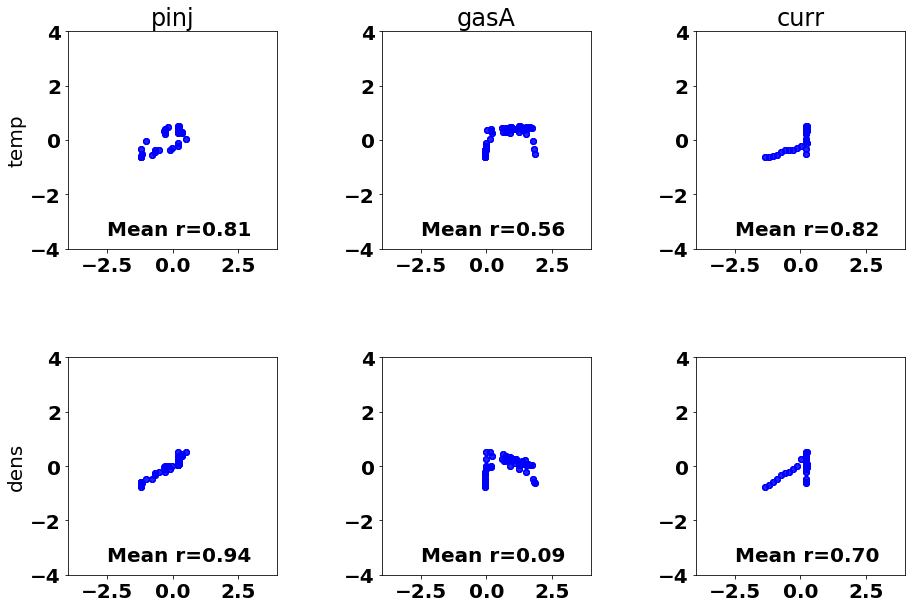

In [92]:
fig=plt.figure()
ind_sigs=['pinj','gasA','curr']
dep_sigs=['temp','dens']

these_shots=shots[::100][:100]
r_values=np.zeros((len(ind_sigs),len(dep_sigs),len(these_shots)))
for k,shot in enumerate(these_shots):
    for j,dep_sig in enumerate(dep_sigs):
        for i,ind_sig in enumerate(ind_sigs):
            ax=fig.add_subplot('{}{}{}'.format(len(dep_sigs),len(ind_sigs),i+j*len(ind_sigs)+1))

            x=data[ind_sig][shot_indices,-param_dict['lookahead']].squeeze()
            y=np.mean(data[dep_sig][shot_indices,-1,:].squeeze(),axis=1)
                
            ax.scatter(x,y,color='b',alpha=.02)
            
            slope, intercept, r_value, p_value, std_err = linregress(x,y)
            #base_x=np.linspace(min(x),max(x),5)
            #ax.plot(base_x,base_x*slope+intercept,alpha=1,c='b')
            r_values[i][j][k]=r_value
            
for j,dep_sig in enumerate(dep_sigs):
    for i,ind_sig in enumerate(ind_sigs):
        ax=fig.add_subplot('{}{}{}'.format(len(dep_sigs),len(ind_sigs),i+j*len(ind_sigs)+1))
        
        if i==0:
            ax.set_ylabel(dep_sig)
        if j==0:
            ax.set_title(ind_sig)

        ax.set_xlim(-4,4)
        ax.set_ylim(-4,4)
        
        ax.text(-2.5,-3.5,'Mean r={0:.2f}'.format(np.mean(r_values[i][j][:])))
            
        
plt.subplots_adjust(hspace=.5)
plt.subplots_adjust(wspace=.5)
plt.show()

ValueError: setting an array element with a sequence.

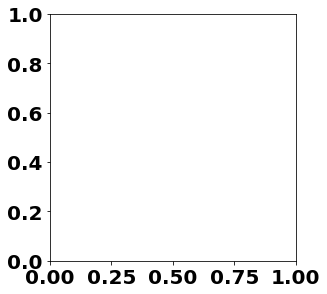

In [114]:
fig=plt.figure()
ind_sigs=['pinj','gasA','curr']
dep_sigs=['temp','dens']

these_shots=shots[::100][:100]
x,y={},{}
for k,shot in enumerate(these_shots):
    for j,dep_sig in enumerate(dep_sigs):
        x[dep_sig]
        for i,ind_sig in enumerate(ind_sigs):
            ax=fig.add_subplot('{}{}{}'.format(len(dep_sigs),len(ind_sigs),i+j*len(ind_sigs)+1))
            np.concatenate(x[i][j],data[ind_sig][shot_indices,-param_dict['lookahead']].squeeze())
            y[i][j][k]=np.mean(data[dep_sig][shot_indices,-param_dict['lookahead'],:].squeeze(),axis=1)
            
for j,dep_sig in enumerate(dep_sigs):
    for i,ind_sig in enumerate(ind_sigs):
        xx=np.concatenate(x[i][j])
        yy=np.concatenate(y[i][j])
        slope, intercept, r_value, p_value, std_err = linregress(xx,yy)

        ax.plot()
        ax=fig.add_subplot('{}{}{}'.format(len(dep_sigs),len(ind_sigs),i+j*len(ind_sigs)+1))
        
        if i==0:
            ax.set_ylabel(dep_sig)
        if j==0:
            ax.set_title(ind_sig)

        ax.set_xlim(-4,4)
        ax.set_ylim(-4,4)
        
        ax.text(-2.5,-3.5,'Mean r={0:.2f}'.format(np.mean(r_value)))
            
        
plt.subplots_adjust(hspace=.5)
plt.subplots_adjust(wspace=.5)
plt.show()

In [108]:
ind_sigs=['pinj','gasA','curr']
dep_sigs=['temp','dens']
offsets=np.arange(1,10)
max_offset=max(offsets)

these_shots=shots[::100][:10]

r_values=np.zeros((len(offsets),len(ind_sigs),len(dep_sigs),len(these_shots)))

for l,offset in enumerate(offsets):
    for k,shot in enumerate(these_shots):
        shot_indices = np.where(data['shotnum'][:,0]==shot)[0]
        for j,dep_sig in enumerate(dep_sigs):
            for i,ind_sig in enumerate(ind_sigs):
                these_indices = shot_indices[:-max_offset]+offset
                
                x = data[ind_sig][these_indices,-param_dict['lookahead']].squeeze()
                y = np.mean(data[dep_sig][these_indices,-param_dict['lookahead'],:].squeeze(),axis=1)

                slope, intercept, r_value, p_value, std_err = linregress(x,y)
                r_values[l][i][j][k] = r_value

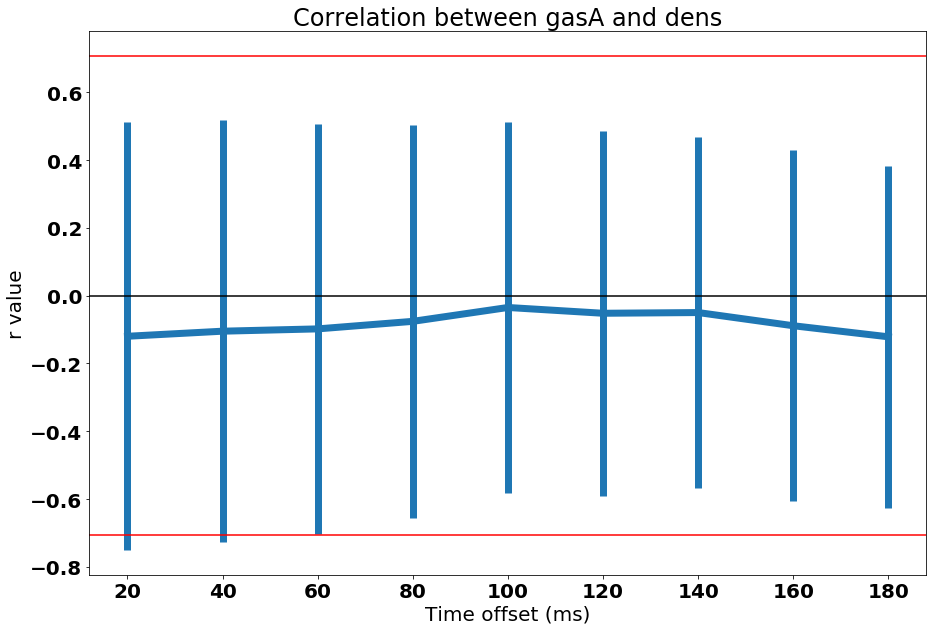

In [111]:
ind_index=1
dep_index=1

correlation=[]
dev=[]
for l in range(len(offsets)):
    correlation.append(np.mean(r_values[l][ind_index][dep_index][:])) #offset, dep, ind, example
    dev.append(np.std(r_values[l][ind_index][dep_index][:]))

plt.figure()
plt.errorbar(offsets*20,correlation,yerr=dev,linewidth=7)
plt.title('Correlation between {} and {}'.format(ind_sigs[ind_index],dep_sigs[dep_index]))
plt.xlabel('Time offset (ms)')
plt.ylabel('r value')
plt.axhline(np.sqrt(.5),color='r')
plt.axhline(-np.sqrt(.5),color='r')
plt.axhline(0,color='k')
plt.show()

Shot: 163833


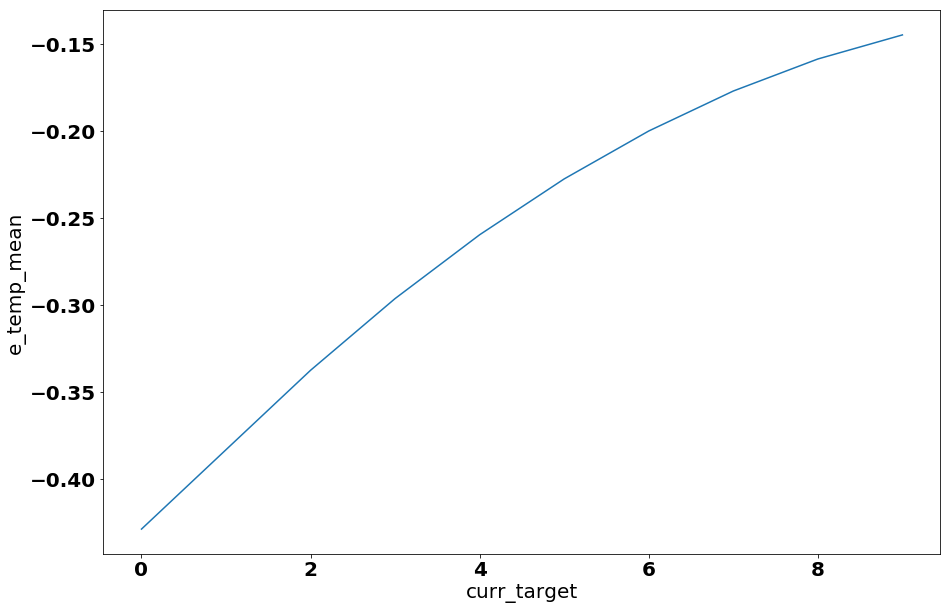

In [153]:
shots=val_shots
shot= shots[np.random.randint(len(shots))]
print('Shot: {}'.format(shot))

fig=plt.figure()
ind_sigs=['pinj','gasA','curr_target']
dep_sigs=['e_temp_mean','e_dens_mean']

ind_sig=ind_sigs[2]
dep_sig=dep_sigs[0]

ax=fig.add_subplot(111)
ax.set_ylabel(dep_sig)
ax.set_xlabel(ind_sig)
# x=normalize(data[shot][ind_sig],ind_sig)
# y=normalize(data[shot][dep_sig],dep_sig)
y=normalize(data[shot][ind_sig],ind_sig)[:10]

# ax.plot(x,y)
# ax.scatter(x[0],y[0])
ax.plot(y)

# slope, intercept, r_value, p_value, std_err = linregress(x,y)
# base_x=np.linspace(min(x),max(x),5)
# ax.plot(base_x,base_x*slope+intercept)
plt.show()